<h1 style="color: #00BFFF;">00 |</h1>

In [134]:
# 📚 Basic libraries
import os # file managment
import matplotlib.pyplot as plt #  plots and visualizations
import numpy as np # numerical python, image array manipulation

# 🛠️ Tools
import warnings # who likes warnings?
import shutil # high-level file operations
import random # to generate random samples

# 🌐 Computer Vision
import cv2 # the most basic library to read images
from tensorflow.keras.preprocessing.image import ImageDataGenerator # real-time data augmentation
from tensorflow.keras.utils import img_to_array, array_to_img, load_img # saving augmented Data
from tensorflow.keras import layers, Model
from tensorflow import keras # deep learning and neural networks

In [99]:
# ⚙️ Settings
warnings.filterwarnings('ignore') # ignore warnings

In [138]:
# 🎯 Specific functions from previous CV projects
def augment_images(data_dir, datagen, num_images=3):
    for filename in os.listdir(data_dir):
        if filename.endswith(".jpeg"):
            img_path = os.path.join(data_dir, filename)
            img_array = img_to_array(load_img(img_path))  # converting the image to numpy array
            img_array = img_array.reshape((1,) + img_array.shape)  # reshape the data

            # Generate new images
            for i, _ in enumerate(datagen.flow(img_array, batch_size=1, save_to_dir=data_dir, save_prefix='aug', save_format='jpeg')):
                if i >= num_images - 1:
                    break
                    
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # downsampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    
    # upsampling
    u1 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)

    # output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return Model(inputs, outputs)

<h1 style="color: #00BFFF;">01 | Data Extraction</h1>

In [100]:
data_path = os.path.join('C:\\Users\\apisi\\01. IronData\\01. GitHub\\03. Projects\\07_hands_on_it', '01_data')
hands = os.path.join(data_path, 'public_hand_dataset')

<h1 style="color: #00BFFF;">02 | Data Cleaning</h1>

In [101]:
# the public hand dataset contains different folders (numeric) with two folders inside of it: no_bg and original
# so, for this challenge I can train a model using the masks provided, and then testing the model with unseen hand images

In [103]:
# first, I will create new folder paths
original = os.path.join(data_path, 'original')
no_bg = os.path.join(data_path, 'no_bg')

# creating the new directories, making sure to not overwrite them if they already exis
os.makedirs(original, exist_ok=True)
os.makedirs(no_bg, exist_ok=True)

In [ ]:
# now I will iterate for each folder inside hands directory
for folder in os.listdir(hands):
    unclean_hands = os.path.join(hands, folder)
    # paths for original and no_bg from the original dataset
    original_unclean = os.path.join(unclean_hands, 'original')
    no_bg_unclean = os.path.join(unclean_hands, 'no_bg')
    # copying (just in case to play it safe) images from each folder
    for image in os.listdir(original_unclean):
        new_image = f"hand_{folder[0:10]}.jpeg" # assigning some numbers from folder ID to my new images
        shutil.copyfile(os.path.join(original_unclean, image), os.path.join(original, new_image))
    for image in os.listdir(no_bg_unclean):
        new_image = f"hand_{folder[0:10]}.jpeg"
        shutil.copyfile(os.path.join(no_bg_unclean, image), os.path.join(no_bg, new_image))

<h1 style="color: #00BFFF;">03 | EDA + Further Cleaning</h1>

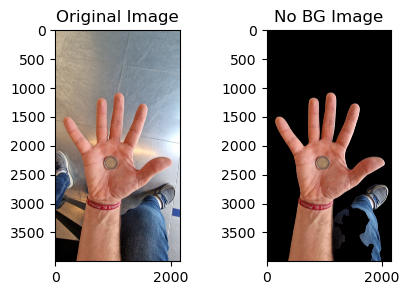

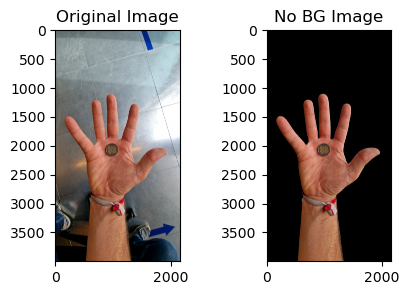

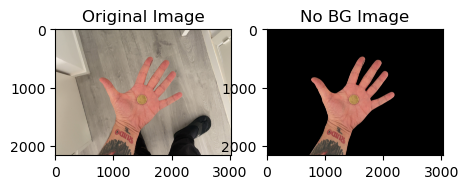

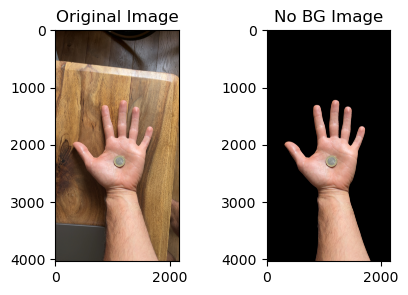

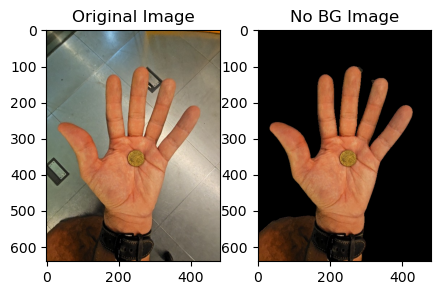

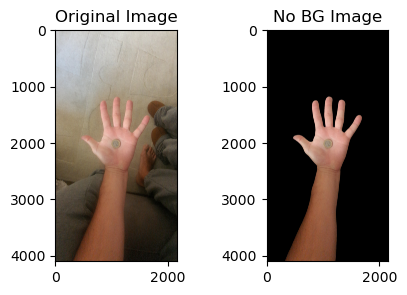

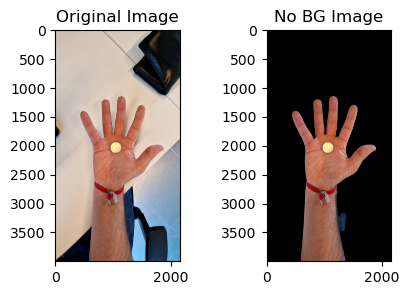

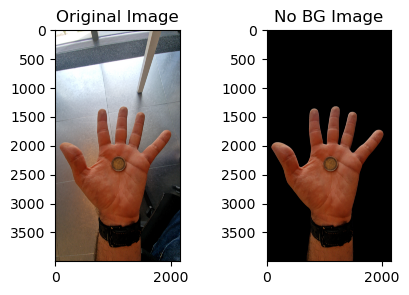

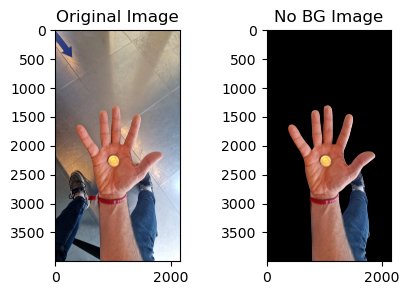

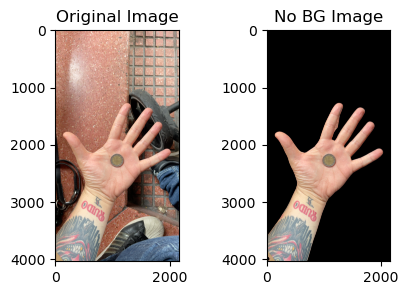

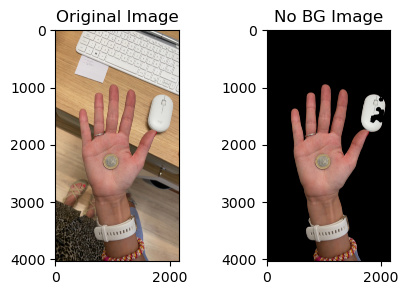

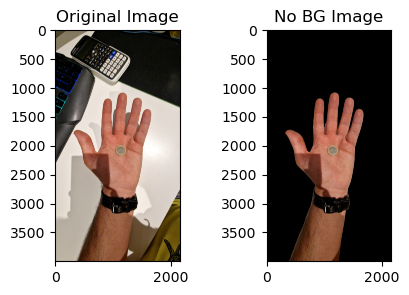

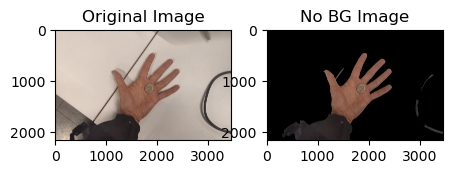

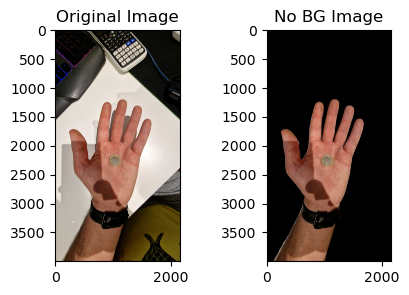

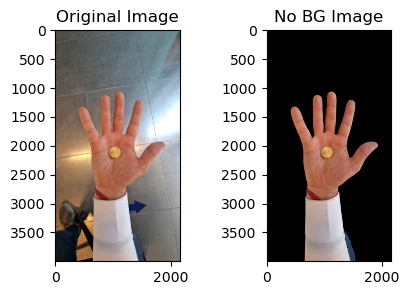

In [35]:
# randomly select a few images to visualize
sample_images = random.sample(os.listdir(original), 15)

# plotting  the images
for img_name in sample_images:
    original_img = cv2.imread(os.path.join(original, img_name))
    no_bg_img = cv2.imread(os.path.join(no_bg, img_name))
    
    plt.figure(figsize=(5, 3))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(no_bg_img, cv2.COLOR_BGR2RGB))
    plt.title('No BG Image')
    
    plt.show()

In [37]:
# From a first quick-exploration I can see many images with different sizes.
# Some of them they don't even have a proper mask with no_bg and others have parts of the background in the hand segmentation

<h3 style="color: #008080;">Exploring Image Sizes</h3>

In [38]:
# Now, I will check all original image files sizes
image_sizes = {}
for img_name in os.listdir(original):
    img = cv2.imread(os.path.join(original, img_name))
    if img.shape[:2] not in image_sizes:
        image_sizes[img.shape[:2]] = 0
    image_sizes[img.shape[:2]] += 1
image_sizes

{(4032, 2160): 56,
 (4000, 2160): 40,
 (2048, 1536): 1,
 (3840, 2160): 11,
 (2160, 3468): 1,
 (4096, 2160): 7,
 (2160, 3024): 17,
 (2160, 3456): 7,
 (2160, 1440): 1,
 (2160, 3072): 1,
 (640, 480): 1,
 (2160, 3000): 4,
 (4080, 2160): 1,
 (1600, 1200): 1,
 (2304, 1728): 1}

<h3 style="color: #008080;">Exploring Aspect Ratios</h3>

In [60]:
# the majority of the images are either 4032 x 2160 or 4000 x 2160
# for the model, I need them to be the same size, but I don't want to distort the original images so I'll firt calculate the aspect ratio
aspect_ratios = {}

# Calculate aspect ratios for each image size
for dimensions, count in image_sizes.items():
    width, height = dimensions
    aspect_ratio = round(width / height, 2)
    aspect_ratios[dimensions, count] = aspect_ratio

aspect_ratios

{((4032, 2160), 56): 1.87,
 ((4000, 2160), 40): 1.85,
 ((2048, 1536), 1): 1.33,
 ((3840, 2160), 11): 1.78,
 ((2160, 3468), 1): 0.62,
 ((4096, 2160), 7): 1.9,
 ((2160, 3024), 17): 0.71,
 ((2160, 3456), 7): 0.62,
 ((2160, 1440), 1): 1.5,
 ((2160, 3072), 1): 0.7,
 ((640, 480), 1): 1.33,
 ((2160, 3000), 4): 0.72,
 ((4080, 2160), 1): 1.89,
 ((1600, 1200), 1): 1.33,
 ((2304, 1728), 1): 1.33}

In [83]:
# The majority of aspect ratios are 1.87, 1.85 from the majority classes
target_aspect_ratios = [1.87, 1.85]

# selecting images with the specific target ratios
selected_images = []

for image in os.listdir(original):
    img = cv2.imread(os.path.join(original, image))
    aspect_ratio = round(img.shape[0] / img.shape[1], 2)
    if aspect_ratio in target_aspect_ratios:
        selected_images.append(image)

print(f"Images safe to resize: {len(selected_images)}")

Images safe to resize: 96


<h3 style="color: #008080;">Clean Datasets</h3>

In [91]:
# now, I will create new folders for the images that I'll resize and use for the mode:
original_clean_path = os.path.join(data_path, '00_original_clean')
no_bg_clean_path = os.path.join(data_path, '00_no_bg_clean')

# creating the new directories, making sure to not overwrite them if they already exis
os.makedirs(original_clean_path, exist_ok=True)
os.makedirs(no_bg_clean_path, exist_ok=True)

In [84]:
# copying the selected images to the new directories
for image in selected_images:
    shutil.copyfile(os.path.join(original, image), os.path.join(original_clean_path, image))
    shutil.copyfile(os.path.join(no_bg, image), os.path.join(no_bg_clean_path, image))

In [68]:
# at this point, I manually checked the folders and I see some images with the background or part of the background in the no_bg folder
# I will delete them manually, also their equivalent in the original dataset to avoid noise in my model

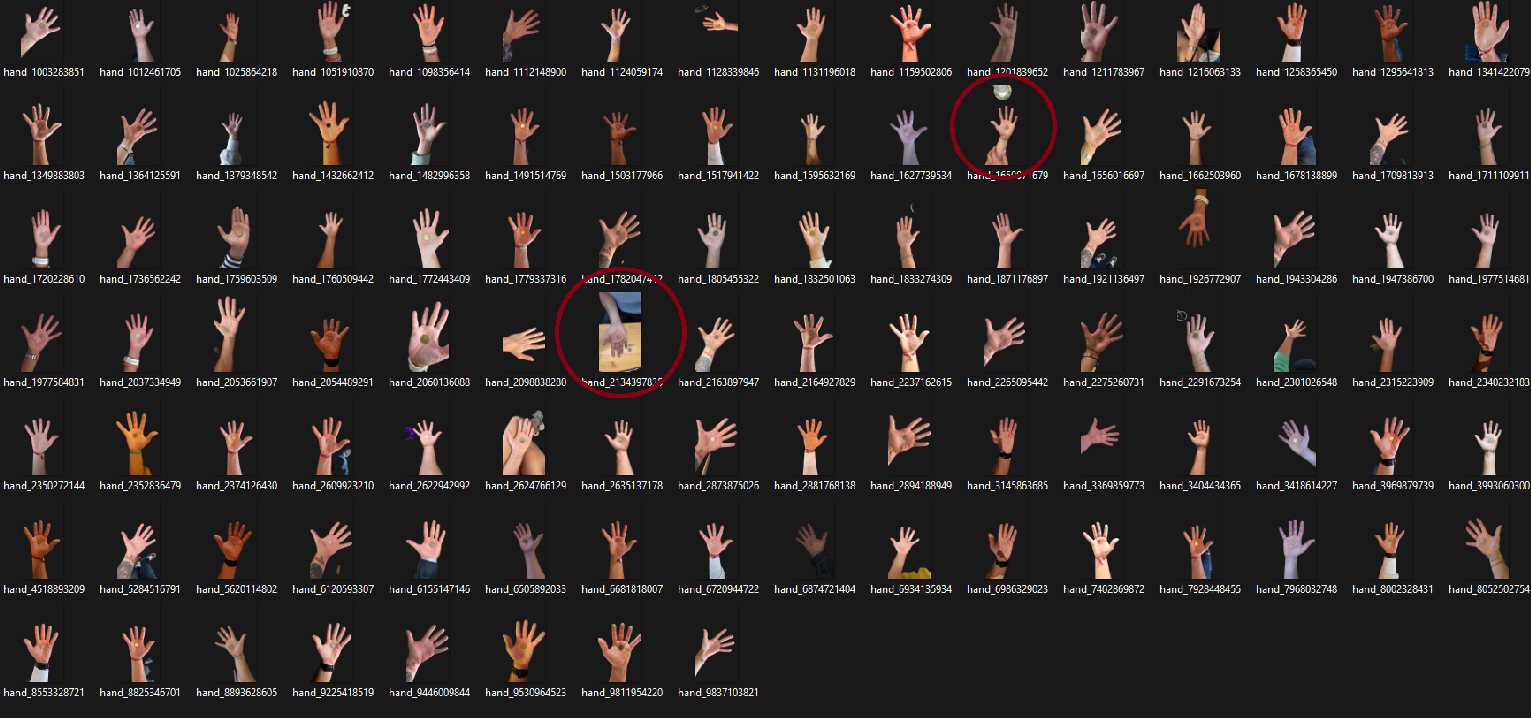

<h3 style="color: #008080;">Obsessive checker is me</h3>

In [85]:
# checking lenghts after cleaning
print(f'Lenght of no_bg_clean: {len(os.listdir(no_bg_clean_path))} and length of original_clean: {len(os.listdir(original_clean_path))}')

Lenght of no_bg_clean: 79 and length of original_clean: 79


<h1 style="color: #00BFFF;">04 | Data Pre-Processing</h1>

<h3 style="color: #008080;">Resizing</h3>

In [87]:
# almost ready !
# now, I'll resize all images to adjust it for the model
size = (2160, 4000)

for image in os.listdir(original_clean_path):
    img_path = os.path.join(original_clean_path, image)
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, size)
    cv2.imwrite(img_path, img_resized)

for image in os.listdir(no_bg_clean_path):
    img_path = os.path.join(no_bg_clean_path, image)
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, size)
    cv2.imwrite(img_path, img_resized)

<h3 style="color: #008080;">Preparing Test folder</h3>

In [92]:
test_dir = os.path.join(data_path, "03_test")
os.makedirs(test_dir, exist_ok=True)
# original and no_bg directories for test
os.makedirs(os.path.join(test_dir, "original"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "no_bg"), exist_ok=True)

<h3 style="color: #008080;">Preparing Train and Validation folder</h3>

In [93]:
train_dir = os.path.join(data_path, "01_train")
val_dir = os.path.join(data_path, "02_validation")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
# original and no_bg directories for train and validation
os.makedirs(os.path.join(train_dir, "original"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "no_bg"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "original"), exist_ok=True)
os.makedirs(os.path.join(val_dir, "no_bg"), exist_ok=True)

<h3 style="color: #008080;">Shuffling the Data</h3>

In [94]:
# Split data
all_images = os.listdir(original_clean_path)
np.random.shuffle(all_images)

<h3 style="color: #008080;">Training and Validation split</h3>

In [96]:
num_train = int(0.8 * len(all_images))
num_val = int(0.1 * len(all_images))
train_images = all_images[:num_train]
val_images = all_images[num_train:num_train+num_val]

for img in train_images:
    shutil.copy(os.path.join(original_clean_path, img), os.path.join(train_dir, 'original', img))
    shutil.copy(os.path.join(no_bg_clean_path, img), os.path.join(train_dir, 'no_bg', img))

for img in val_images:
    shutil.copy(os.path.join(original_clean_path, img), os.path.join(val_dir, 'original', img))
    shutil.copy(os.path.join(no_bg_clean_path, img), os.path.join(val_dir, 'no_bg', img))

<h3 style="color: #008080;">Unique images for Test</h3>

In [97]:
test_images = all_images[num_train+num_val:]
for img in test_images:
    shutil.copy(os.path.join(original_clean_path, img), os.path.join(test_dir, 'original', img))
    shutil.copy(os.path.join(no_bg_clean_path, img), os.path.join(test_dir, 'no_bg', img))

In [112]:
# We will perform some Data Augmentation to the training folder
datagen = ImageDataGenerator(
    brightness_range=[0.5, 1.5],  # different brightness intensities
    zoom_range=0.2                # simulates variable zoom size
)
augment_images(os.patgth.join(train_dir, 'original'), datagen, num_images=3)
augment_images(os.path.join(train_dir, 'no_bg'), datagen, num_images=3)

<h1 style="color: #00BFFF;">05 | Modeling</h1>

<h3 style="color: #008080;">Fine-Tunning the Model</h3>

In [121]:
# Parameters that we can fine-tune later on
img_height = 4000
img_width = 2160
image_size = (img_height, img_width)
batch_size = 16

<h3 style="color: #008080;">Train and Validation Data</h3>

In [124]:
val_datagen = ImageDataGenerator()
train_datagen = ImageDataGenerator()

In [125]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 501 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


<h3 style="color: #008080;">Compiling the Model</h3>

In [132]:
model = unet_model((2160, 4000, 3))

In [135]:
model.compile(
    optimizer=keras.optimizers.Adamax(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [136]:
checkpoints = os.path.join(data_path, "04_epochs", "save_at_{epoch}.keras")

In [139]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoints),
]

hist = model.fit(
    train_ds, 
    epochs=epochs, 
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/30


ValueError: in user code:

    File "C:\Users\apisi\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\apisi\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\apisi\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\apisi\anaconda3\lib\site-packages\keras\engine\training.py", line 1052, in train_step
        self._validate_target_and_loss(y, loss)
    File "C:\Users\apisi\anaconda3\lib\site-packages\keras\engine\training.py", line 1006, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=binary_crossentropy, and therefore expects target data to be provided in `fit()`.
